# exploratory data analysis<a id='3_Exploratory_Data_Analysis'></a>

## contents
* [introduction](#introduction)
* [imports and load](#imports_and_load)
* [exploration](#exploration_start)
    - [check for bias](#bias_check)
        - [bias in race](#race)
        - [type of diabetes](#type)
    - [demographic visualizations](#demo_viz)
    - [demographic readmit ratios](#demo_rat)

## introduction<a id='introduction'></a>

The goal of this analysis will be to understand this data more fully.  This exploration will inform modelling decisions and possibly reveal insights itself.  This work will include reviewing distributions, scaling, encoding and testing interactions.  Additional data may be merged during exploration as needed and available.

## imports and load<a id='imports_and_load'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline

Pip requirements for reproducibility

In [2]:
pip list --format=freeze > requirements-2-ja-eda.ipynb.txt

Note: you may need to restart the kernel to use updated packages.


Start with the output of the data wrangling and confirm load

In [3]:
admissions = pd.read_csv('../data/interim/notebook1_output.csv', 
                         index_col='encounter_id')
print(admissions.shape)
admissions.head(3)

(101727, 38)


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),Other,Other,physicial referral,1,41,0,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),emergency,home,emergency room,3,59,0,...,No,No,No,No,No,Up,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),emergency,home,emergency room,2,11,5,...,No,No,No,No,No,No,No,No,Yes,NO


## exploration<a id='exploration_start'></a>

### check for bias<a id='bias_check'></a>

#### race<a id='race'></a>

As there are demographics present, there is an opportunity to know if any particular group is over or under represented.  Race alone is the first target.  The 2000 [US Census](https://www2.census.gov/library/publications/decennial/2000/briefs/c2kbr01-01.pdf) reports a full population racial mix of 75.1% white and 12.3% black.

The American Diabetes Association [ADA](https://diabetes.org/about-us/statistics/about-diabetes#:~:text=Diabetes%20by%20race%2Fethnicity&text=12.1%25%20of%20non%2DHispanic%20blacks,7.4%25%20of%20non%2DHispanic%20whites) reports that 12.1% of  non-hispanic blacks and 7.4% of non-hispanic whites have diabetes diagnoses.  Ethnicity was not captured in this dataset so cannot be tested.




In [4]:
print('unique race values:', admissions.race.unique())
twoRace = admissions[admissions.race != 'Other']
twoRace_counts = twoRace.race.value_counts()
twoRace_fractions = twoRace.race.value_counts('normalize=True')

adj_white_count = twoRace_counts['Caucasian'] * 7.4
adj_black_count = twoRace_counts['AfricanAmerican'] * 12.1
adj_total = adj_white_count + adj_black_count
adj_white_perc = adj_white_count / adj_total
adj_black_perc = adj_black_count / adj_total
print('expected white fraction:', adj_white_perc)
print('observed white fraction:', twoRace_fractions['Caucasian'])
print('expected black fraction:', adj_black_perc)
print('observed black fraction:', twoRace_fractions['AfricanAmerican'])

unique race values: ['Caucasian' 'AfricanAmerican' 'Other']
expected white fraction: 0.7078017567818881
observed white fraction: 0.798421378564756
expected black fraction: 0.29219824321811194
observed black fraction: 0.201578621435244


To make this dataset unbiased, observations with a race value of "Caucasian" should make up ~71% of all observations.  The number of observations over that can be removed at random.

In [5]:
np.random.seed(42)
count_black = twoRace.race.value_counts()['AfricanAmerican']
count_white = twoRace.race.value_counts()['Caucasian']
white_to_remove = int(count_white - (count_black / 0.29 - count_black ))
raceWhite = twoRace[twoRace['race'] == 'Caucasian']
raceWhite = raceWhite.sample(raceWhite.shape[0] - white_to_remove)
raceBlack = twoRace[twoRace['race'] == 'AfricanAmerican']
twoRace = pd.concat( [raceBlack, raceWhite])
twoRace.race.value_counts('normalize=True')

Caucasian          0.710004
AfricanAmerican    0.289996
Name: race, dtype: float64

#### type of diabetes<a id='type'></a>

From here, statistics vary widely on prevalance of type 1 and type 2 diabetes by gender and age.  In general, males are more likely to have diabetes than females, but the gap between the sexes is smaller for type 1.  This dataset does contain the first 3 diagnoses for each admission.  Both ICD9 and ICD10 diagnoses codes are used.  ICD9 codes for diabetes start with 250 and ICD10 codes for type 1 start with E10 and type 2 start with E11.

In [6]:
twoRace[~(twoRace['diag_1'].str.contains('250')) &
        ~(twoRace['diag_1'].str.contains('E1')) &
        ~(twoRace['diag_2'].str.contains('250')) & 
        ~(twoRace['diag_2'].str.contains('E1')) &
        ~(twoRace['diag_3'].str.contains('250')) & 
        ~(twoRace['diag_3'].str.contains('E1')) 
       ].shape[0] / twoRace.shape[0] 

0.6218346545866364

Unfortunately, 62% of the observations here don't have any diabetes type diagnoses codes included.  Demographic bias corrections end here.

### demographic visualization <a id='demo_viz'></a>

<Figure size 640x480 with 0 Axes>

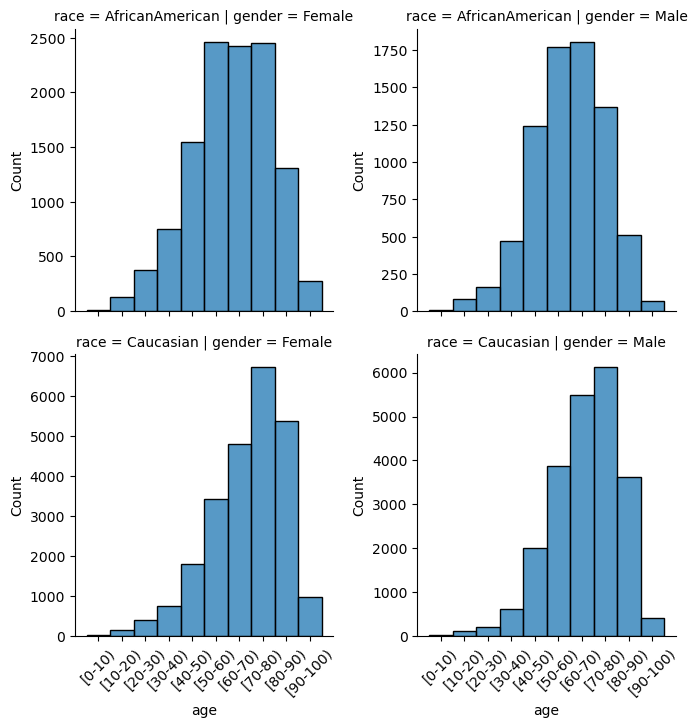

In [18]:
twoRace['age'] = pd.Categorical(twoRace['age'], ['[0-10)', '[10-20)', '[20-30)', '[30-40)', 
    '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)',])

plt.clf()

g = sns.FacetGrid(
    twoRace,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.histplot, 'age')

for axes in g.axes.flat:
    for label in axes.get_xticklabels():
        label.set_rotation(45)

plt.show()

These distributions show that the various demographic combinations remaining in the dataset are well represented.  How are these combinations related to the readmission variable?  For this, I'll only be concerned with whether or not readmission happened and not whether or not in happened within 30 days.  I'll look at the readmit rate for each race, gender, age group combination.

<Figure size 640x480 with 0 Axes>

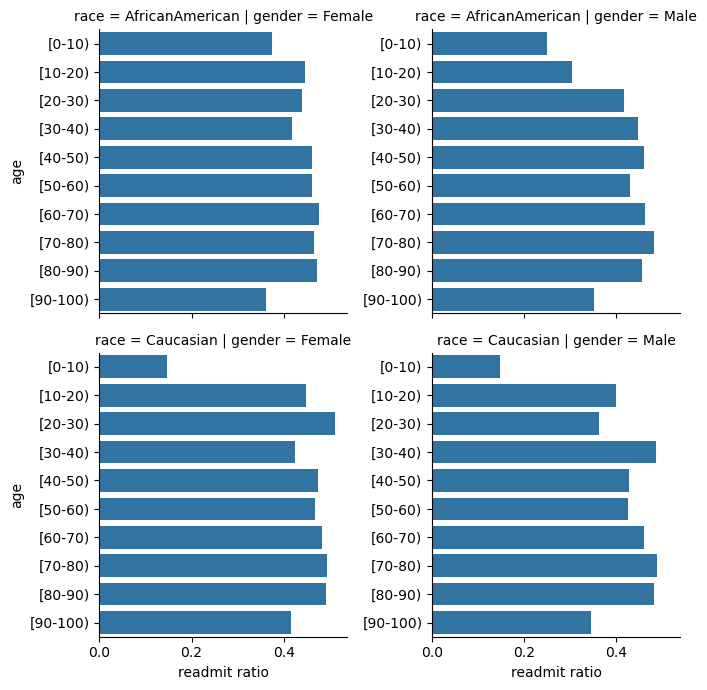

In [15]:
readmitMapping = {'NO': 0, '>30': 1, '<30': 1}
twoRace['readmitBinary'] = twoRace['readmitted'].replace(to_replace=readmitMapping)
demographic_readmit_mean = twoRace.groupby(['race','age','gender'])\
                           .agg([np.mean])['readmitBinary']\
                           .reset_index()

plt.clf()
g = sns.FacetGrid(
    demographic_readmit_mean,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.barplot, 'mean', 'age')

[axes.set_xlabel('readmit ratio') for axes in g.axes.flat]

plt.show()

### demographic readmit ratios <a id='demo_rat'></a>

There are 3 notable items here.  
1. The 0-10 age group is very different between races
2. African American males 10-20 have a lower readmission rate than other groups
3. The 90-100 group has a lower ratio than most other age groups for each race/gender combination.

I suspect all 3 of these can be explained with a small sample size

In [43]:
demographic_counts = twoRace.groupby(['race','age','gender'])['patient_nbr'].count()
demographic_counts = demographic_counts.to_frame().reset_index()
demographic_counts[(demographic_counts['age'] == '[0-10)') | 
                   (demographic_counts['age'] == '[90-100)') | 
                   ((demographic_counts['age'] == '[10-20)') &
                    (demographic_counts['race'] == 'AfricanAmerican')
                   )]

,race,age,gender,patient_nbr
0,AfricanAmerican,[0-10),Female,8
1,AfricanAmerican,[0-10),Male,8
2,AfricanAmerican,[10-20),Female,130
3,AfricanAmerican,[10-20),Male,79
18,AfricanAmerican,[90-100),Female,274
19,AfricanAmerican,[90-100),Male,71
20,Caucasian,[0-10),Female,41
21,Caucasian,[0-10),Male,41
38,Caucasian,[90-100),Female,982
39,Caucasian,[90-100),Male,408


The small sample idea does hold for item 1 (0-10 age group), but not the other 2 questions.  Its possible that item 3 could be explained as this age group expiring during the admission more often than the others.  

In [45]:
twoRace['discharge_disposition_id'].unique()

array(['home', 'snf', 'Other', 'home health'], dtype=object)

Expiration would fit into the 'Other' category, but so would transferred, etc.  Being discharged to a skilled nursing facility (SNF) or home health could also explain the lack of readmission as these would help with adherence to medical advice given at discharge.

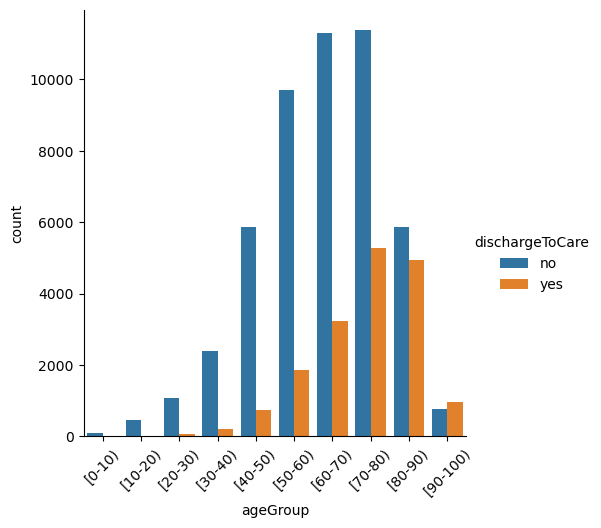

In [62]:
discharge_age_counts = twoRace.groupby(['age','discharge_disposition_id'])['patient_nbr'].count()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

discharge_age_counts.columns = ['ageGroup','dischargeToCare','count']
to_replace = {'Other': 'no', 'home': 'no', 'home health': 'yes', 'snf': 'yes'}
discharge_age_counts['dischargeToCare'].replace(to_replace, inplace=True)
discharge_age_counts = discharge_age_counts.groupby(['ageGroup','dischargeToCare'])['count'].sum()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

_ = sns.catplot(data=discharge_age_counts
    , x='ageGroup' 
    , y='count' 
    , hue='dischargeToCare'
    , kind='bar'
)
plt.xticks(rotation=45)

plt.show()

The 90-100 age group is the only one where a patient is discharged to care more often than not.  The ratio of discharged to care vs not also increases with age after 30.  What does that look like?